### Authorship
@author: Alexandre Pereira Santos <br>
alexandre.santos(at)lmu.de<br>
- many scripts in this notebook com from geemap (see below)

### Tasks
- get Sentinel2 data using the Google Earth Engine functionalities
- clip it to an AOI

### Prerequisites
- earth engine api (ee) https://developers.google.com/earth-engine/apidocs
- gee map (gee), https://geemap.org/ by Qiusheng Wu
- create an account and a Google Cloud project in Google Developer, see here: https://developers.google.com/earth-engine/guides/auth

# init

In [1]:
import ee
import geemap
from pathlib import Path
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# 

In [2]:
# Authenticate and initialize Earth Engine
ee.Authenticate()
ee.Initialize(project='ee-alexandresantosgeographie') # Replace with your GEE project
print(ee.__version__)

0.1.388


In [3]:
#defining filter funcions for Sentinel data
#code from https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR_HARMONIZED#colab-python

def mask_s2_clouds(image):
  """Masks clouds in a Sentinel-2 image using the QA band.

  Args:
      image (ee.Image): A Sentinel-2 image.

  Returns:
      ee.Image: A cloud-masked Sentinel-2 image.
  """
  qa = image.select('QA60')

  # Bits 10 and 11 are clouds and cirrus, respectively.
  cloud_bit_mask = 1 << 10
  cirrus_bit_mask = 1 << 11

  # Both flags should be set to zero, indicating clear conditions.
  mask = (
      qa.bitwiseAnd(cloud_bit_mask)
      .eq(0)
      .And(qa.bitwiseAnd(cirrus_bit_mask).eq(0))
  )

  return image.updateMask(mask).divide(10000)

In [4]:
# check if the authentication is working
print(ee.Image("NASA/NASADEM_HGT/001").get("title").getInfo())

NASADEM: NASA NASADEM Digital Elevation 30m


# imports

In [51]:
#input a vector and a raster file
AOI_path = Path('../../data/processed/')
#AOI_file = 'MAN_LIM_BoundingBox_AOI_A.shp' #Manila
AOI_file = 'JAK_LIM_BoundingBox_AOI_A.shp' #Jakarta
#AOI_file = 'MUM_LIM_BoundingBox_AOI_A.shp' #Mumbai

AOI_gdf = gpd.read_file(AOI_path/AOI_file)

# extract coordinates from the bounding box
aoi_coords = AOI_gdf.to_crs(epsg='4326').envelope
#print('N',aoi_coords.bounds.values[0][3],'S',aoi_coords.bounds.values[0][1],'W',aoi_coords.bounds.values[0][0],'E',aoi_coords.bounds.values[0][2])
transform = [aoi_coords.bounds.values[0][0], aoi_coords.bounds.values[0][1], aoi_coords.bounds.values[0][2], aoi_coords.bounds.values[0][3]]
roi = ee.Geometry.BBox(west=transform[0], south=transform[1], east=transform[2], north=transform[3])
rec_roi = ee.Geometry.Rectangle(transform[0],transform[1],transform[2],transform[3])
coi = roi.centroid(maxError=1)
#coi = AOI_gdf.to_crs(epsg='4326').dissolve().centroid.to_crs('EPSG:4326').geometry.apply(lambda x: (x.x, x.y)).values[0]
aoi_crs = AOI_gdf.crs.to_epsg()
#print(coords)

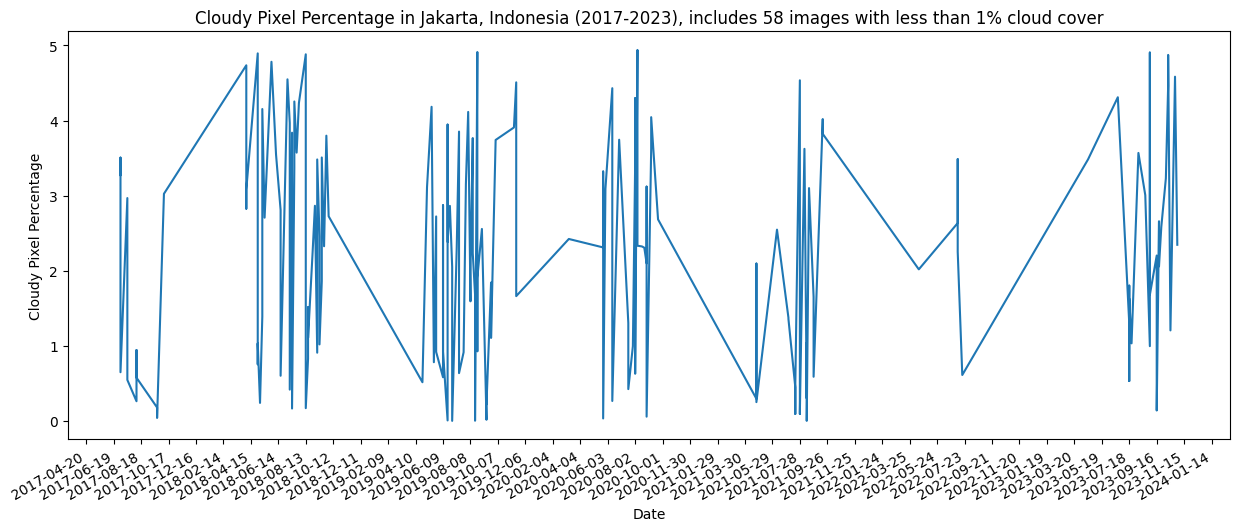

In [43]:
# Define your ImageCollection #S2_SR_HARMONIZED or S2
sentinel2 = ee.ImageCollection("COPERNICUS/S2") \
    .filterBounds(roi) \
    .filterDate('2017-06-01','2023-12-01') \
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 5))

# Get the list of dates
dates = sentinel2.aggregate_array('system:time_start').map(lambda time_start: ee.Date(time_start).format('YYYY-MM-dd')).getInfo()

# Get the list of CLOUDY_PIXEL_PERCENTAGE values
cloudy_pixel_percentage_list = sentinel2.reduceColumns(ee.Reducer.toList(), ["CLOUDY_PIXEL_PERCENTAGE"]).get('list')

# Convert to Python list
cloudy_pixel_percentage_py_list = ee.List(cloudy_pixel_percentage_list).getInfo()

# Convert dates to datetime objects
dates = [mdates.datestr2num(date) for date in dates]

# Filter the ImageCollection based on CLOUDY_PIXEL_PERCENTAGE < 1
filtered_collection = sentinel2.filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 1))

# Get the list of dates
filtered_dates = filtered_collection.aggregate_array('system:time_start').map(lambda time_start: ee.Date(time_start).format('YYYY-MM-dd')).getInfo()

# Plot the data
plt.figure(figsize=(15, 6))
plt.plot_date(dates, cloudy_pixel_percentage_py_list, '-')
title_str = 'Cloudy Pixel Percentage in Jakarta, Indonesia (2017-2023), includes '+str(len(filtered_dates))+' images with less than 1% cloud cover'
plt.title(title_str)
plt.xlabel('Date')
plt.ylabel('Cloudy Pixel Percentage')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=60))  # set interval = 60 days
plt.gcf().autofmt_xdate()  # rotate and align the x labels
plt.show()

In [44]:
min_cloud_image = filtered_collection.sort('CLOUDY_PIXEL_PERCENTAGE').first()
print(min_cloud_image)

ee.Image({
  "functionInvocationValue": {
    "functionName": "Collection.first",
    "arguments": {
      "collection": {
        "functionInvocationValue": {
          "functionName": "Collection.limit",
          "arguments": {
            "collection": {
              "functionInvocationValue": {
                "functionName": "Collection.filter",
                "arguments": {
                  "collection": {
                    "functionInvocationValue": {
                      "functionName": "Collection.filter",
                      "arguments": {
                        "collection": {
                          "functionInvocationValue": {
                            "functionName": "Collection.filter",
                            "arguments": {
                              "collection": {
                                "functionInvocationValue": {
                                  "functionName": "Collection.filter",
                                  "arguments": {
     

In [70]:
# creating a cloud mask
#code from https://github.com/giswqs/earthengine-py-notebooks/blob/master/Algorithms/CloudMasking/sentinel-2.ipynb
# Add Earth Engine dataset
# This example uses the Sentinel-2 QA band to cloud mask
# the collection.  The Sentinel-2 cloud flags are less
# selective, so the collection is also pre-filtered by the
# CLOUDY_PIXEL_PERCENTAGE flag, to use only relatively
# cloud-free granule.

Map = geemap.Map()
Map.centerObject(coi, zoom=9)

# Function to mask clouds using the Sentinel-2 QA band.
# function maskS2clouds(image) {
def maskS2clouds(image):
  qa = image.select('QA60')

  # Bits 10 and 11 are clouds and cirrus, respectively.
  cloudBitMask = 1 << 10
  cirrusBitMask = 1 << 11

  # Both flags should be set to zero, indicating clear conditions.
  mask = qa.bitwiseAnd(cloudBitMask).eq(0).And(
             qa.bitwiseAnd(cirrusBitMask).eq(0))

  # Return the masked and scaled data, without the QA bands.
  return image.updateMask(mask).divide(10000) \
      .select("B.*") \
      .copyProperties(image, ["system:time_start"])
# }

# Map the function over one year of data and take the median.
# Load Sentinel-2 TOA reflectance data.
collection = ee.ImageCollection('COPERNICUS/S2') \
    .filterDate(filtered_dates[0],filtered_dates[-1]) \
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20)) \
    .map(maskS2clouds)

composite = collection.median()

# Display the results.
Map.addLayer(composite, {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 0.3}, 'RGB')
Map.addLayer(roi, {}, 'ROI')
Map

Map(center=[-6.356096336666425, 106.74822478594142], controls=(WidgetControl(options=['position', 'transparent…

In [32]:
type(composite)

ee.image.Image

In [64]:
projection = composite.select('B2').projection().getInfo()
print(projection['crs'])

EPSG:4326


In [34]:
crs='EPSG:'+str(aoi_crs)
print(crs)

EPSG:32748


In [65]:
task = ee.batch.Export.image.toDrive(
    image=composite,
    description='image_export_crstransform',
    folder='data',
    region=rec_roi,
    crsTransform=projection['transform'],
    crs=projection['crs'],
    maxPixels=1e13,
    formatOptions={
        'cloudOptimized': True
    }
)
task.start()

In [77]:
#composite = collection.median()
cloud_composite = ee.Image(collection.sort('CLOUDY_PIXEL_PERCENTAGE').first())

# Display the results.
Map.addLayer(cloud_composite, {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 0.3}, 'RGB')
Map

In [ ]:
# Add Earth Engine dataset
collection = ee.ImageCollection('USDA/NAIP/DOQQ')

polys = ee.Geometry.Polygon(
        [[[-99.29615020751953, 46.725459351792374],
          [-99.2116928100586, 46.72404725733022],
          [-99.21443939208984, 46.772037733479884],
          [-99.30267333984375, 46.77321343419932]]])

centroid = polys.centroid()
lng, lat = centroid.getInfo()['coordinates']
print("lng = {}, lat = {}".format(lng, lat))

lng_lat = ee.Geometry.Point(lng, lat)
naip = collection.filterBounds(polys)
naip_2015 = naip.filterDate('2015-01-01', '2015-12-31')
ppr = naip_2015.mosaic()

count = naip_2015.size().getInfo()
print("Count: ", count)

# print(naip_2015.size().getInfo())
# vis = {'bands': ['N', 'R', 'G']}
# Map.setCenter(lng, lat, 12)
# Map.addLayer(ppr,vis)
# Map.addLayer(polys)

downConfig = {'scale': 30, "maxPixels": 1.0E13, 'driveFolder': 'image'}  # scale means resolution.
img_lst = naip_2015.toList(100)

for i in range(0, count):
    image = ee.Image(img_lst.get(i))
    name = image.get('system:index').getInfo()
    # print(name)
    task = ee.batch.Export.image(image, name, downConfig)
    task.start()

In [67]:
# Export the images as a mosaic in TIFF format
export_path = '../../data/raw/sentinel2_mosaic/'
export_image = ee.ImageCollection(composite).mosaic()
task = ee.batch.Export.image.toDrive(
    image=export_image,
    description='Mosaic Export',
    folder=export_path,
    scale=10,
    fileFormat='GeoTIFF'
)
task.start()